In [4]:
%matplotlib inline

import pandas as pd
import numpy as np
from os.path import join
import matplotlib.pyplot as plt
from os import walk
plt.rc('figure', figsize = (5, 4))

# Evaluation de l'impact du cleaning des vols 

#### cleaning = programme clean_vol.py de Nicolas

    all_datas : Dataframe avec tous les vols non cleanés

    all_datas_cleaned : Dataframe avec les vols renvoyés par le programme clean_vol : 221 vols supprimés et valeur de la jauge lissée.
    
    Le but de ce notebook : Evaluer l'impact de ce cleaning : temps de vols, ratio Jauge / Débit

Les résultats : 
    - Les vols jugés trop courts, à altitude et vitesse constante ont bien été supprimés
    - La variable jauge semble être bien lissée

#### DF représente all_datas et DF1 représente all_data_cleaned

In [5]:
path = '/Users/mayliscotadze/Documents/Safran/'

In [6]:
df = pd.read_csv(path + 'all_datas.csv', sep=",", header=0, encoding="latin 1")

In [7]:
df = df.drop('Unnamed: 0', axis = 1)

In [10]:
df1 = pd.read_csv(path + 'all_datas_cleaned.csv', sep=",", header=0, encoding="latin 1")

In [13]:
df1 = df1.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis = 1)

In [15]:
df.shape, df1.shape

((4619345, 18), (4588473, 18))

## 1) Evaluation de l'impact du cleaning sur le temps de vol

        221 vols jugés trop courts ont été supprimés par le cleaning

In [41]:
df_flight_time_min = df.pivot_table(index = 'n_vol', values= 'time', aggfunc = lambda x: len(x)*2/60)

In [17]:
df1_flight_time_min = df1.pivot_table(index = 'n_vol', values= 'time', aggfunc = lambda x: len(x)*2/60)

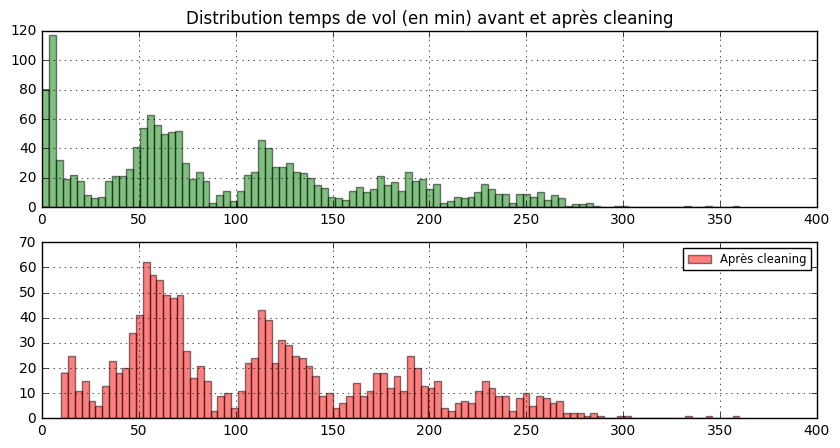

In [36]:
fig, axes = plt.subplots(2,1, figsize=(10,5))

axes[0].set_title('Distribution temps de vol (en min) avant et après cleaning')
df_flight_time_min.hist(bins = 100, color = 'green', alpha=0.5, ax = axes[0], label = 'Distibution des temps de vols avant cleaning')
df1_flight_time_min.hist(bins = 100, color = 'red', alpha=0.5, ax = axes[1], label = 'Après cleaning')
plt.legend(fontsize = 'small')

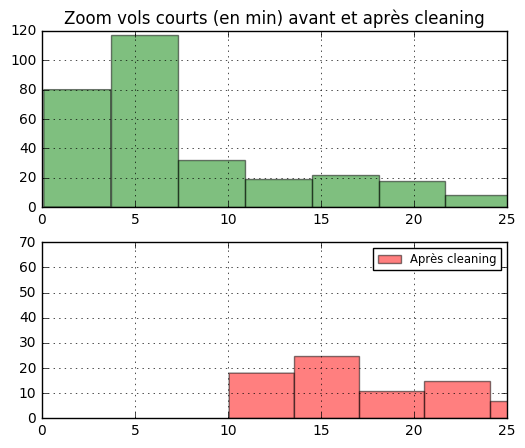

In [40]:
fig, axes = plt.subplots(2,1, figsize=(6,5))
axes[0].set_title('Zoom vols courts (en min) avant et après cleaning')
axes[0].set_xlim([0, 25])
axes[1].set_xlim([0, 25])
df_flight_time_min.hist(bins = 100, color = 'green', alpha=0.5, ax = axes[0], label = 'Distibution des temps de vols avant cleaning')
df1_flight_time_min.hist(bins = 100, color = 'red', alpha=0.5, ax = axes[1], label = 'Après cleaning')
plt.legend(fontsize = 'small')

In [42]:
# Details about the distribution in equal size 4 'bins'
# Avant cleaning
time_qcut = pd.qcut(df_flight_time_min, 4)
time_qcut.value_counts().sort_index()

[0.1, 46.7]            394
(46.7, 75.0333]        393
(75.0333, 141.667]     396
(141.667, 360.0333]    390
Name: time, dtype: int64

In [43]:
# Après cleaning
time_qcut1 = pd.qcut(df1_flight_time_min, 4)
time_qcut1.value_counts().sort_index()

[10.0667, 58.233]      338
(58.233, 105.6]        337
(105.6, 163.533]       337
(163.533, 360.0333]    337
Name: time, dtype: int64

## 2) Verification suppression des vols à altitude et vitesse constante

In [46]:
# Avant cleaning, vols à altitude constante
df_std_altitude = df.pivot_table(index = 'n_vol', values= 'altitude', aggfunc = np.std)

In [47]:
df_std_altitude[df_std_altitude == 0] 

n_vol
0051-1.csv    0.0
0286-1.csv    0.0
0324-2.csv    0.0
0555-4.csv    0.0
Name: altitude, dtype: float64

In [48]:
# Après cleaning, vols à altitude constante
df1_std_altitude = df1.pivot_table(index = 'n_vol', values= 'altitude', aggfunc = np.std)
df1_std_altitude[df1_std_altitude == 0] 

Series([], Name: altitude, dtype: float64)

    ==> Les vols à altitude constante ont bien été supprimés

In [51]:
# Avant cleaning, vols à ground speed constante
df_std_groundSpeed = df.pivot_table(index = 'n_vol', values= 'ground speed', aggfunc = np.std)
df_std_groundSpeed[df_std_groundSpeed == 0].shape

(92,)

In [53]:
# Après cleaning, vols à vitesse constante
df1_std_groundSpeed = df1.pivot_table(index = 'n_vol', values= 'ground speed', aggfunc = np.std)
df1_std_groundSpeed[df1_std_groundSpeed == 0]

Series([], Name: ground speed, dtype: float64)

    ==> Les 92 vols à ground speed constante ont bien été supprimés

## Evaluation de l'impact du cleaning de la variable jauge

In [54]:
df_flow_vol = pd.DataFrame(df, columns=['n_vol', 'fuel flow', 'fuel vol']).set_index('n_vol')
df1_flow_vol = pd.DataFrame(df1, columns=['n_vol', 'fuel flow', 'fuel vol']).set_index('n_vol')

#### Calcul du fuel (en kg) capteur JAUGE et capteur DEBIT / pas 2 sec

In [55]:
# Avant cleaning
for flight in set(df_flow_vol.index) : 
    fuel_vol_flight = df_flow_vol.ix[flight, 'fuel vol']
    fuel_vol_flight_diff = - fuel_vol_flight.diff()
    df_flow_vol.ix[flight, 'diff_jauge_2sec'] =  fuel_vol_flight_diff
    df_flow_vol.ix[flight, 'vol_debit_2sec'] =  df_flow_vol.ix[flight, 'fuel flow'] / 1800

In [57]:
df_flow_vol.head(3)

,fuel flow,fuel vol,diff_jauge_2sec,vol_debit_2sec
n_vol,,,,
0001-1.csv,58.2,99,NaN,0.032333
0001-1.csv,44.5,99,-0.0,0.024722
0001-1.csv,32.1,99,-0.0,0.017833


In [58]:
# Après cleaning
for flight in set(df1_flow_vol.index) : 
    fuel_vol_flight = df1_flow_vol.ix[flight, 'fuel vol']
    fuel_vol_flight_diff = - fuel_vol_flight.diff()
    df1_flow_vol.ix[flight, 'diff_jauge_2sec'] =  fuel_vol_flight_diff
    df1_flow_vol.ix[flight, 'vol_debit_2sec'] =  df1_flow_vol.ix[flight, 'fuel flow'] / 1800

In [59]:
df1_flow_vol.head(3)

,fuel flow,fuel vol,diff_jauge_2sec,vol_debit_2sec
n_vol,,,,
0001-3.csv,58.2,273.0,NaN,0.032333
0001-3.csv,46.6,273.0,-0.0,0.025889
0001-3.csv,33.1,273.0,-0.0,0.018389


#### Somme par vol des colonnes diff_jauge_2sec et vol_debit_2sec pour les comparer

In [60]:
df_diff_jauge_debit = pd.DataFrame(columns = ['sum_vol_jauge', 'sum_vol_debit'])
for flight in set(df_flow_vol.index) : 
    df_diff_jauge_debit.ix[flight, 'sum_vol_jauge'] =  np.sum(df_flow_vol.ix[flight, 'diff_jauge_2sec'])
    df_diff_jauge_debit.ix[flight, 'sum_vol_debit'] =  np.sum(df_flow_vol.ix[flight, 'vol_debit_2sec'])

In [61]:
df_diff_jauge_debit.head(3)

,sum_vol_jauge,sum_vol_debit
0561-2.csv,69,65.1521
0091-4.csv,130,121.162
0295-3.csv,-41,176.649


In [62]:
df1_diff_jauge_debit = pd.DataFrame(columns = ['sum_vol_jauge', 'sum_vol_debit'])
for flight in set(df1_flow_vol.index) : 
    df1_diff_jauge_debit.ix[flight, 'sum_vol_jauge'] =  np.sum(df1_flow_vol.ix[flight, 'diff_jauge_2sec'])
    df1_diff_jauge_debit.ix[flight, 'sum_vol_debit'] =  np.sum(df1_flow_vol.ix[flight, 'vol_debit_2sec'])

In [63]:
df1_diff_jauge_debit.head(3)

,sum_vol_jauge,sum_vol_debit
0317-1.csv,24,23.1989
0312-1.csv,-8,124.223
0561-2.csv,69,65.1521


#### Flights with jauge_start - jauge_end = 0

In [64]:
len(df_diff_jauge_debit[df_diff_jauge_debit.sum_vol_jauge == 0])

16

In [65]:
len(df1_diff_jauge_debit[df1_diff_jauge_debit.sum_vol_jauge == 0])

4

In [71]:
df_sum_jauge_zero = df_diff_jauge_debit[df_diff_jauge_debit.sum_vol_jauge == 0]

In [67]:
# Après cleaning il reste 4 vols avec jauge start = jauge end
df1_sum_jauge_zero = df1_diff_jauge_debit[df1_diff_jauge_debit.sum_vol_jauge == 0]
df1_sum_jauge_zero.index

Index(['0282-1.csv', '0210-1.csv', '0254-2.csv', '0233-3.csv'], dtype='object')

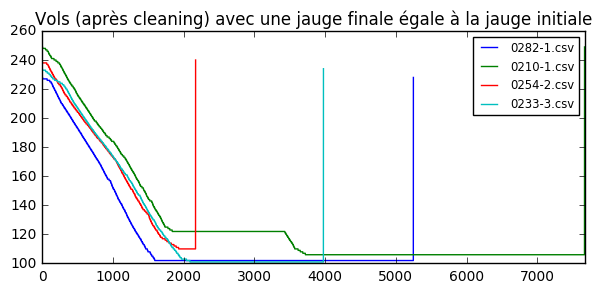

In [99]:
fig, axes = plt.subplots(1,1, figsize=(7, 3))
for flight in df1_sum_jauge_zero.index:
    df1_flow_vol.ix[flight, 'fuel vol'].plot(label = flight, use_index = False)
plt.legend(loc='best', fontsize = 'small')
plt.title("Vols (après cleaning) avec une jauge finale égale à la jauge initiale")

In [72]:
# On enlève ces vols pour pouvoir ensuite calculer le ratio
df_diff_jauge_debit = df_diff_jauge_debit.drop(df_sum_jauge_zero.index)
df1_diff_jauge_debit = df1_diff_jauge_debit.drop(df1_sum_jauge_zero.index)

In [73]:
df_diff_jauge_debit['ratio_abs'] = np.abs((df_diff_jauge_debit['sum_vol_debit']/ df_diff_jauge_debit['sum_vol_jauge'] - 1)*100)
df1_diff_jauge_debit['ratio_abs'] = np.abs((df1_diff_jauge_debit['sum_vol_debit']/ df1_diff_jauge_debit['sum_vol_jauge'] - 1)*100)

In [74]:
ratio_qcut = pd.qcut(df_diff_jauge_debit.ratio_abs, 4)
ratio_qcut.value_counts().sort_index()

[0.104, 7.315]          390
(7.315, 34.383]         389
(34.383, 209.624]       389
(209.624, 48857.567]    389
Name: ratio_abs, dtype: int64

In [75]:
ratio_qcut_1 = pd.qcut(df1_diff_jauge_debit.ratio_abs, 4)
ratio_qcut_1.value_counts().sort_index()

[0.104, 7.0484]         337
(7.0484, 77.253]        336
(77.253, 261.685]       336
(261.685, 48857.567]    336
Name: ratio_abs, dtype: int64

### Visualisation des vols à gros ratio puis à faible ratio avant cleaning

In [76]:
def viz_flight_big_ratio(start, end):
    # Attention flight big ratio est classé par ordre descendant
    flight_big_ratio = df_diff_jauge_debit.sort_values('ratio_abs', ascending = False).index[start: end]
    ncol = 6
    nrow = 5
    fig, axes = plt.subplots(nrow, ncol, figsize=(15, 10))
    k=0
    for i in range(nrow):
        for j in range(ncol):
            df_flow_vol.ix[flight_big_ratio[k], 'fuel vol'].plot(label = flight_big_ratio[k], use_index = False, ax=axes[i][j], color = 'g', alpha = 0.3, xticks = [])      
            k += 1            

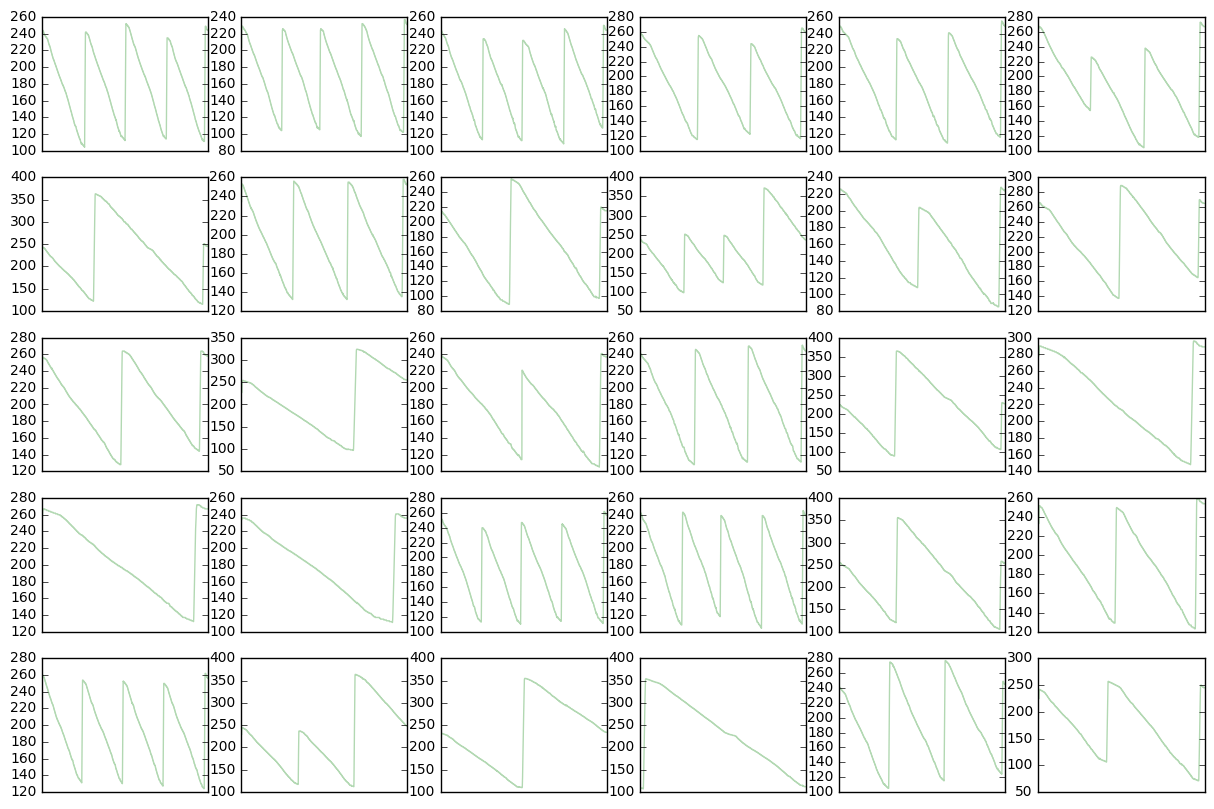

In [77]:
# Visualisation des vols à plus gros ratio
viz_flight_big_ratio(0, 30)

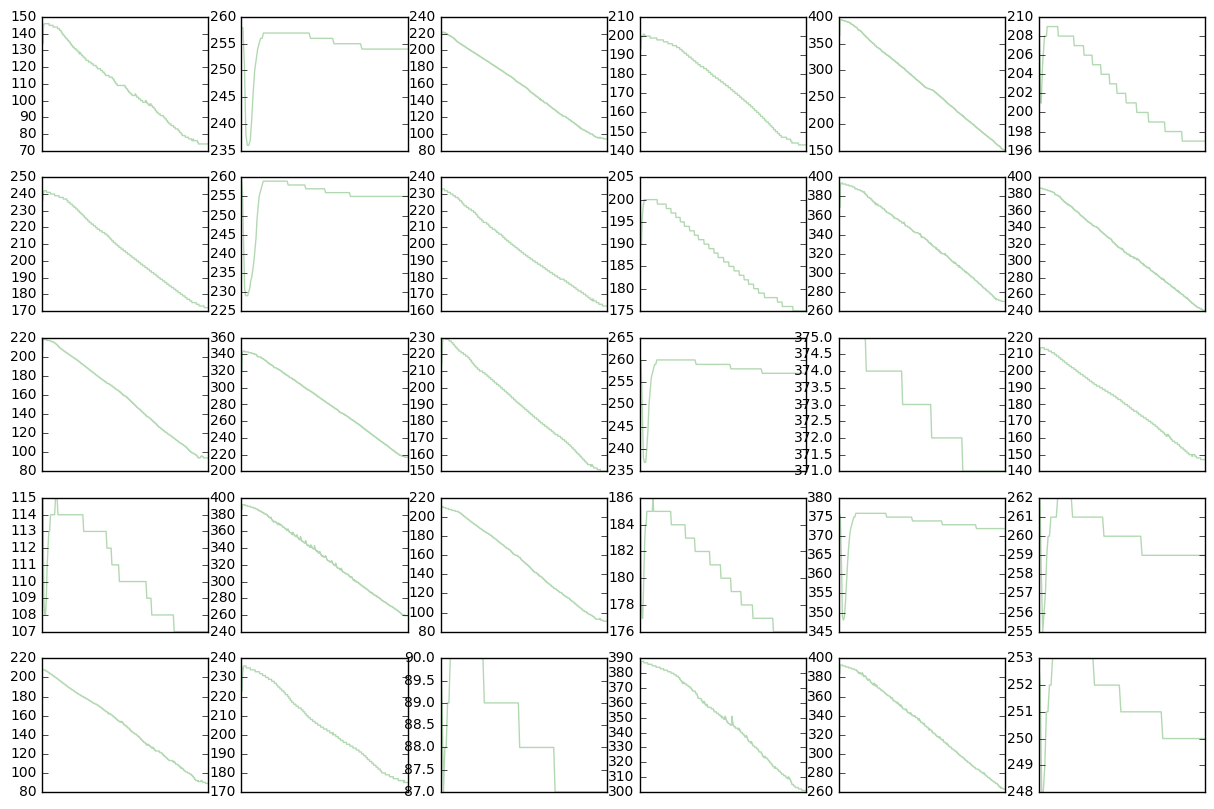

In [78]:
# Viz des vols à plus faible ratio
viz_flight_big_ratio(-31, -1)

### Visualisation des vols à gros ratio puis à faible ratio après cleaning

In [79]:
def viz_flight_big_ratio_1(start, end):
    # Attention flight big ratio est classé par ordre descendant
    flight_big_ratio = df1_diff_jauge_debit.sort_values('ratio_abs', ascending = False).index[start: end]
    ncol = 6
    nrow = 5
    fig, axes = plt.subplots(nrow, ncol, figsize=(15, 10))
    k=0
    for i in range(nrow):
        for j in range(ncol):
            df1_flow_vol.ix[flight_big_ratio[k], 'fuel vol'].plot(label = flight_big_ratio[k], use_index = False, ax=axes[i][j], color = 'g', alpha = 0.3, xticks = [])      
            k += 1            

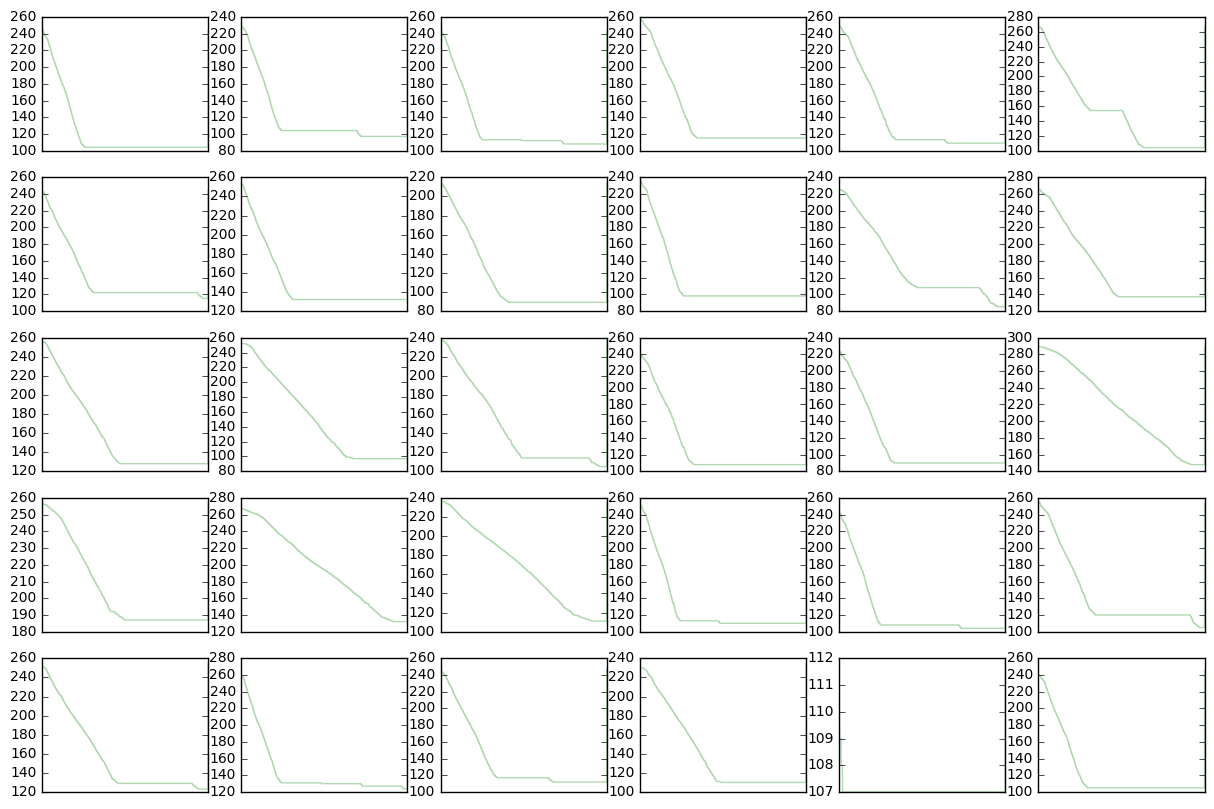

In [80]:
# Visualisation des vols à plus gros ratio
viz_flight_big_ratio_1(0, 30)

    ==> La jauge a bien été lissée par le cleaning

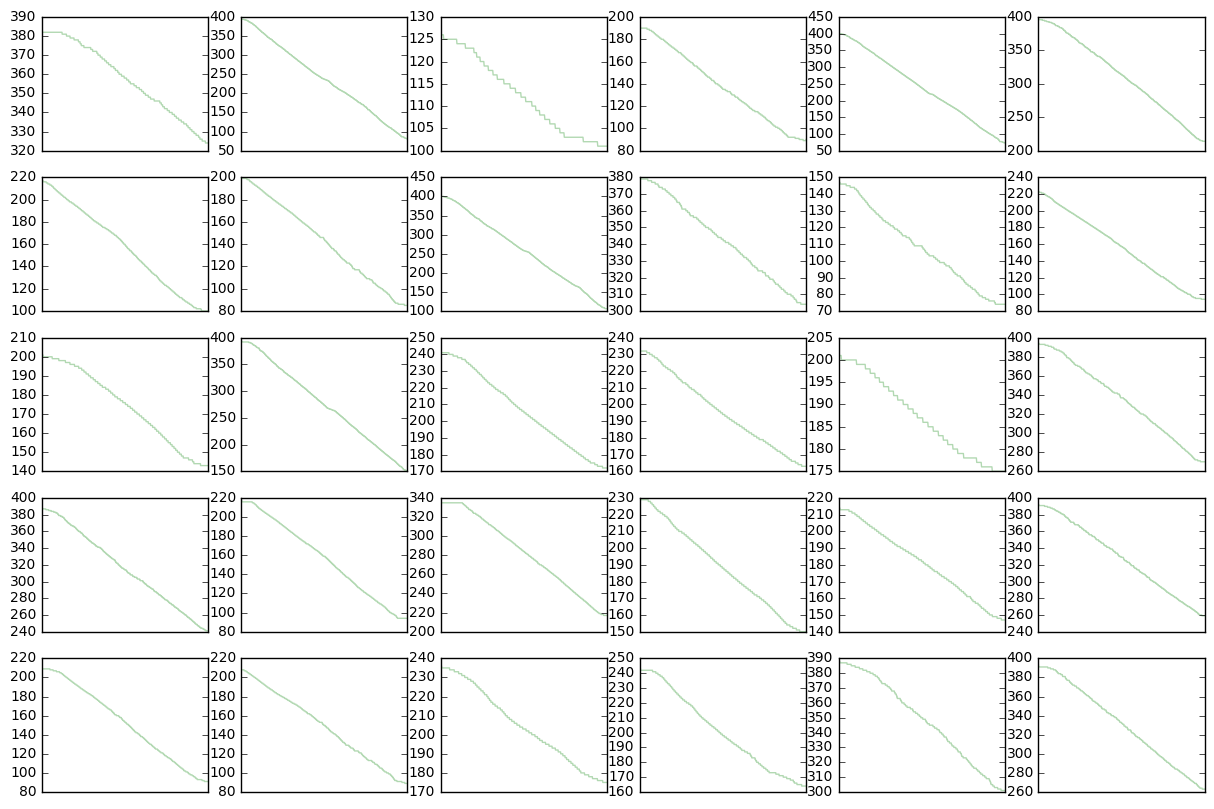

In [98]:
# Viz des vols à plus faible ratio
viz_flight_big_ratio_1(-31, -1)

    ==> On remarque que les creux en début de vol ont bien été lissés par le cleaning